In [98]:
import psycopg2
import pandas as pd
import numpy as np
import pickle as pkl
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

pd.set_option('display.max_columns',300)
pd.set_option('display.max_rows',300)

In [2]:
host = '119.8.167.24'
port = '5432'
username = 'team27'
password = 'bill-mirror-nerve27'
database = 'mimiciv' #mimic

In [3]:
con = psycopg2.connect(database=database, user=username, password=password, host=host, port=port)

In [4]:
cur = con.cursor()

In [5]:
mode = 'load' # 'query' or 'load'

# Hospital and ICU cohort

In [448]:
query = '''
    select 

    adm_patient.gender,
    adm_patient.anchor_age,
    adm_patient.dod,
    admittime, 
    dischtime, 
    deathtime, 
    admission_type, 
    admission_location, 
    discharge_location, 
    insurance,edregtime, 
    edouttime,
    hospital_expire_flag,
    icu.*,
    DATE_PART('day',dischtime - admittime)+1 as hosp_los

    from
    (
        select *
            from mimic_core.admissions adm
        join 
            mimic_core.patients pat
        on pat.subject_id = adm.subject_id
        where pat.anchor_age >= 18
        --and adm.hospital_expire_flag = 0 

      ) adm_patient

    join mimic_icu.icustays icu
    on adm_patient.hadm_id = icu.hadm_id

    '''

death_2wks = pd.read_sql(query, con)

In [449]:
def getDead(row):
    if row['hospital_expire_flag'] == 1 or row['discharge_location'] == 'DIED':
        return 1
    else:
        return 0

In [450]:
death_2wks['Mortalized'] = death_2wks.apply(getDead,1)
death_2wks = death_2wks.rename(columns={'los':'icu_los'})

In [11]:
# %%time

# if mode == 'query':

#     query = '''
#     select 

#     adm_patient.gender,
#     adm_patient.anchor_age,
#     adm_patient.dod,
#     admittime, 
#     dischtime, 
#     deathtime, 
#     admission_type, 
#     admission_location, 
#     discharge_location, 
#     insurance,edregtime, 
#     edouttime,
#     hospital_expire_flag,
#     first_icu.*,
#     DATE_PART('day',dischtime - admittime)+1 as hosp_los

#     from
#     (
#         select *
#             from mimic_core.admissions adm
#         join 
#             mimic_core.patients pat
#         on pat.subject_id = adm.subject_id
#         where pat.anchor_age >= 18
#         and adm.hospital_expire_flag = 0 

#       ) adm_patient

#     join

#     (
#         select icu.*
#             from mimic_icu.icustays icu
#         join
#         (
#             select hadm_id  , min(intime) as min_intime 
#             FROM 
#                 mimic_icu.icustays 
#             GROUP BY hadm_id 
#         ) first_
#         on icu.hadm_id = first_.hadm_id and icu.intime = first_.min_intime

#     ) first_icu
#     on adm_patient.hadm_id = first_icu.hadm_id


#     '''

#     hosp_icu = pd.read_sql(query, con)

In [6]:
# if mode == 'query':
#     with open('hosp_icu.pkl', 'wb') as f:
#         pkl.dump(hosp_icu, f)
# elif mode == 'load':
#     with open('hosp_icu.pkl', 'rb') as f:
#         hosp_icu = pkl.load(f)

In [7]:
# hosp_icu = hosp_icu.rename(columns={'los':'icu_los'})

In [8]:
# hosp_icu.shape

(58101, 22)

In [9]:
# hosp_icu.head()

,gender,anchor_age,dod,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,edregtime,edouttime,hospital_expire_flag,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,icu_los,hosp_los
0,M,71,None,2121-08-30 16:33:00,2121-09-03 15:45:00,None,URGENT,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicare,NaT,NaT,0,14990224,20000147,37348463,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2121-08-30 18:08:39,2121-08-31 21:29:49,1.139699,3.0
1,M,63,None,2125-10-26 00:00:00,2125-10-28 19:25:00,None,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicaid,NaT,NaT,0,15975141,20001494,39346951,Neuro Intermediate,Neuro Intermediate,2125-10-26 17:34:33,2125-10-28 19:33:26,2.082558,2.0
2,M,64,None,2196-06-12 00:00:00,2196-06-19 20:01:00,None,ELECTIVE,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,NaT,NaT,0,17112572,20001687,32926753,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2196-06-13 09:18:36,2196-06-15 10:34:07,2.052442,7.0
3,M,56,None,2157-09-23 23:24:00,2157-09-29 14:20:00,None,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,2157-09-23 18:09:00,2157-09-24 01:01:00,0,18826698,20002252,35781968,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-09-24 01:01:00,2157-09-24 15:32:48,0.605417,5.0
4,M,46,None,2156-08-31 14:52:00,2156-09-03 11:15:00,None,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,NaT,NaT,0,18346781,20002270,38835257,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2156-08-31 14:52:54,2156-09-01 02:07:59,0.468808,2.0


# Ventilator queries

In [99]:
%%time
query = '''
SELECT subject_id, stay_id, charttime FROM (
  select vs.subject_id, ce.stay_id, vs.charttime, vs.ventilator_mode, vs.extubated from mimic_derived.ventilator_setting vs 
  JOIN (select subject_id, stay_id, charttime from mimic_icu.chartevents ) ce
  on  vs.subject_id = ce.subject_id and vs.charttime = ce.charttime
  where extubated = 1) vsce
  GROUP BY subject_id, stay_id, charttime
'''

vs = pd.read_sql(query, con)

query = '''
select *, DATE_PART('day', endtime - starttime)+1 as vent_duration from mimic_derived.ventilator_durations vd
'''

vd = pd.read_sql(query, con)

Wall time: 584 ms


In [10]:
if mode == 'query':
    with open('vs.pkl', 'wb') as f:
        pkl.dump(vs, f)
    with open('vd.pkl', 'wb') as f:
        pkl.dump(vd, f)   
elif mode == 'load':
    with open('vs.pkl', 'rb') as f:
        vs = pkl.load(f)
    with open('vd.pkl', 'rb') as f:
        vd = pkl.load(f)

In [11]:
vs.shape, vd.shape

((6161, 3), (28908, 5))

In [12]:
vsvd = pd.merge(vs, vd, on=['stay_id'])

In [13]:
vsvd[vsvd['subject_id']==16108683]

,subject_id,stay_id,charttime,ventnum,starttime,endtime,vent_duration
3,16108683,38197814,2120-11-21 16:10:00,1,2120-11-10 04:00:00,2120-11-12 16:09:00,3.0
4,16108683,38197814,2120-11-21 16:10:00,2,2120-11-12 23:00:00,2120-11-21 16:10:00,9.0
5,16108683,38197814,2120-11-21 16:10:00,3,2120-11-22 02:12:00,2120-11-27 18:00:00,6.0
6,16108683,38197814,2120-11-27 18:00:00,1,2120-11-10 04:00:00,2120-11-12 16:09:00,3.0
7,16108683,38197814,2120-11-27 18:00:00,2,2120-11-12 23:00:00,2120-11-21 16:10:00,9.0
8,16108683,38197814,2120-11-27 18:00:00,3,2120-11-22 02:12:00,2120-11-27 18:00:00,6.0


In [14]:
vsvd1 = pd.merge(vs, vd, left_on=['stay_id','charttime'], right_on=['stay_id','endtime'])

In [156]:
vsvd1.shape

(4778, 3)

In [15]:
vsvd1[vsvd1['subject_id']==16108683]

,subject_id,stay_id,charttime,ventnum,starttime,endtime,vent_duration
3,16108683,38197814,2120-11-21 16:10:00,2,2120-11-12 23:00:00,2120-11-21 16:10:00,9.0
2727,16108683,38197814,2120-11-27 18:00:00,3,2120-11-22 02:12:00,2120-11-27 18:00:00,6.0


In [16]:
vsvd1 = vsvd1.groupby(['subject_id','stay_id']).agg({'vent_duration':'sum'}).reset_index()

In [17]:
vsvd1[vsvd1['subject_id']==16108683]

,subject_id,stay_id,vent_duration
2938,16108683,38197814,15.0


In [18]:
hosp_icu[hosp_icu['stay_id']==38197814]

,gender,anchor_age,dod,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,edregtime,edouttime,hospital_expire_flag,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,icu_los,hosp_los
16964,M,41,None,2120-11-08 15:02:00,2121-03-12 14:40:00,None,URGENT,TRANSFER FROM HOSPITAL,REHAB,Medicaid,NaT,NaT,0,16108683,21607477,38197814,Coronary Care Unit (CCU),Medical/Surgical Intensive Care Unit (MICU/SICU),2120-11-10 03:56:33,2120-11-29 17:46:11,19.576134,123.0


## CCI

In [8]:
%%time # Wall time: 2min 5s

if mode == 'query':

    query = '''
    WITH diag AS
    (
        SELECT 
            hadm_id
            , CASE WHEN icd_version = 9 THEN icd_code ELSE NULL END AS icd9_code
            , CASE WHEN icd_version = 10 THEN icd_code ELSE NULL END AS icd10_code
        FROM mimic_hosp.diagnoses_icd diag
    )
    , com AS
    (
        SELECT
            ad.hadm_id

            -- Myocardial infarction
            , MAX(CASE WHEN
                SUBSTR(icd9_code, 1, 3) IN ('410','412')
                OR
                SUBSTR(icd10_code, 1, 3) IN ('I21','I22')
                OR
                SUBSTR(icd10_code, 1, 4) = 'I252'
                THEN 1 
                ELSE 0 END) AS myocardial_infarct

            -- Congestive heart failure
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) = '428'
                OR
                SUBSTR(icd9_code, 1, 5) IN ('39891','40201','40211','40291','40401','40403',
                              '40411','40413','40491','40493')
                OR 
                SUBSTR(icd9_code, 1, 4) BETWEEN '4254' AND '4259'
                OR
                SUBSTR(icd10_code, 1, 3) IN ('I43','I50')
                OR
                SUBSTR(icd10_code, 1, 4) IN ('I099','I110','I130','I132','I255','I420',
                                                       'I425','I426','I427','I428','I429','P290')
                THEN 1 
                ELSE 0 END) AS congestive_heart_failure

            -- Peripheral vascular disease
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) IN ('440','441')
                OR
                SUBSTR(icd9_code, 1, 4) IN ('0930','4373','4471','5571','5579','V434')
                OR
                SUBSTR(icd9_code, 1, 4) BETWEEN '4431' AND '4439'
                OR
                SUBSTR(icd10_code, 1, 3) IN ('I70','I71')
                OR
                SUBSTR(icd10_code, 1, 4) IN ('I731','I738','I739','I771','I790',
                                                       'I792','K551','K558','K559','Z958','Z959')
                THEN 1 
                ELSE 0 END) AS peripheral_vascular_disease

            -- Cerebrovascular disease
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) BETWEEN '430' AND '438'
                OR
                SUBSTR(icd9_code, 1, 5) = '36234'
                OR
                SUBSTR(icd10_code, 1, 3) IN ('G45','G46')
                OR 
                SUBSTR(icd10_code, 1, 3) BETWEEN 'I60' AND 'I69'
                OR
                SUBSTR(icd10_code, 1, 4) = 'H340'
                THEN 1 
                ELSE 0 END) AS cerebrovascular_disease

            -- Dementia
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) = '290'
                OR
                SUBSTR(icd9_code, 1, 4) IN ('2941','3312')
                OR
                SUBSTR(icd10_code, 1, 3) IN ('F00','F01','F02','F03','G30')
                OR
                SUBSTR(icd10_code, 1, 4) IN ('F051','G311')
                THEN 1 
                ELSE 0 END) AS dementia

            -- Chronic pulmonary disease
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) BETWEEN '490' AND '505'
                OR
                SUBSTR(icd9_code, 1, 4) IN ('4168','4169','5064','5081','5088')
                OR 
                SUBSTR(icd10_code, 1, 3) BETWEEN 'J40' AND 'J47'
                OR 
                SUBSTR(icd10_code, 1, 3) BETWEEN 'J60' AND 'J67'
                OR
                SUBSTR(icd10_code, 1, 4) IN ('I278','I279','J684','J701','J703')
                THEN 1 
                ELSE 0 END) AS chronic_pulmonary_disease

            -- Rheumatic disease
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) = '725'
                OR
                SUBSTR(icd9_code, 1, 4) IN ('4465','7100','7101','7102','7103',
                                                      '7104','7140','7141','7142','7148')
                OR
                SUBSTR(icd10_code, 1, 3) IN ('M05','M06','M32','M33','M34')
                OR
                SUBSTR(icd10_code, 1, 4) IN ('M315','M351','M353','M360')
                THEN 1 
                ELSE 0 END) AS rheumatic_disease

            -- Peptic ulcer disease
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) IN ('531','532','533','534')
                OR
                SUBSTR(icd10_code, 1, 3) IN ('K25','K26','K27','K28')
                THEN 1 
                ELSE 0 END) AS peptic_ulcer_disease

            -- Mild liver disease
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) IN ('570','571')
                OR
                SUBSTR(icd9_code, 1, 4) IN ('0706','0709','5733','5734','5738','5739','V427')
                OR
                SUBSTR(icd9_code, 1, 5) IN ('07022','07023','07032','07033','07044','07054')
                OR
                SUBSTR(icd10_code, 1, 3) IN ('B18','K73','K74')
                OR
                SUBSTR(icd10_code, 1, 4) IN ('K700','K701','K702','K703','K709','K713',
                                                       'K714','K715','K717','K760','K762',
                                                       'K763','K764','K768','K769','Z944')
                THEN 1 
                ELSE 0 END) AS mild_liver_disease

            -- Diabetes without chronic complication
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 4) IN ('2500','2501','2502','2503','2508','2509') 
                OR
                SUBSTR(icd10_code, 1, 4) IN ('E100','E10l','E106','E108','E109','E110','E111',
                                                       'E116','E118','E119','E120','E121','E126','E128',
                                                       'E129','E130','E131','E136','E138','E139','E140',
                                                       'E141','E146','E148','E149')
                THEN 1 
                ELSE 0 END) AS diabetes_without_cc

            -- Diabetes with chronic complication
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 4) IN ('2504','2505','2506','2507')
                OR
                SUBSTR(icd10_code, 1, 4) IN ('E102','E103','E104','E105','E107','E112','E113',
                                                       'E114','E115','E117','E122','E123','E124','E125',
                                                       'E127','E132','E133','E134','E135','E137','E142',
                                                       'E143','E144','E145','E147')
                THEN 1 
                ELSE 0 END) AS diabetes_with_cc

            -- Hemiplegia or paraplegia
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) IN ('342','343')
                OR
                SUBSTR(icd9_code, 1, 4) IN ('3341','3440','3441','3442',
                                                      '3443','3444','3445','3446','3449')
                OR 
                SUBSTR(icd10_code, 1, 3) IN ('G81','G82')
                OR 
                SUBSTR(icd10_code, 1, 4) IN ('G041','G114','G801','G802','G830',
                                                       'G831','G832','G833','G834','G839')
                THEN 1 
                ELSE 0 END) AS paraplegia

            -- Renal disease
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) IN ('582','585','586','V56')
                OR
                SUBSTR(icd9_code, 1, 4) IN ('5880','V420','V451')
                OR
                SUBSTR(icd9_code, 1, 4) BETWEEN '5830' AND '5837'
                OR
                SUBSTR(icd9_code, 1, 5) IN ('40301','40311','40391','40402','40403','40412','40413','40492','40493')          
                OR
                SUBSTR(icd10_code, 1, 3) IN ('N18','N19')
                OR
                SUBSTR(icd10_code, 1, 4) IN ('I120','I131','N032','N033','N034',
                                                       'N035','N036','N037','N052','N053',
                                                       'N054','N055','N056','N057','N250',
                                                       'Z490','Z491','Z492','Z940','Z992')
                THEN 1 
                ELSE 0 END) AS renal_disease

            -- Any malignancy, including lymphoma and leukemia, except malignant neoplasm of skin
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) BETWEEN '140' AND '172'
                OR
                SUBSTR(icd9_code, 1, 4) BETWEEN '1740' AND '1958'
                OR
                SUBSTR(icd9_code, 1, 3) BETWEEN '200' AND '208'
                OR
                SUBSTR(icd9_code, 1, 4) = '2386'
                OR
                SUBSTR(icd10_code, 1, 3) IN ('C43','C88')
                OR
                SUBSTR(icd10_code, 1, 3) BETWEEN 'C00' AND 'C26'
                OR
                SUBSTR(icd10_code, 1, 3) BETWEEN 'C30' AND 'C34'
                OR
                SUBSTR(icd10_code, 1, 3) BETWEEN 'C37' AND 'C41'
                OR
                SUBSTR(icd10_code, 1, 3) BETWEEN 'C45' AND 'C58'
                OR
                SUBSTR(icd10_code, 1, 3) BETWEEN 'C60' AND 'C76'
                OR
                SUBSTR(icd10_code, 1, 3) BETWEEN 'C81' AND 'C85'
                OR
                SUBSTR(icd10_code, 1, 3) BETWEEN 'C90' AND 'C97'
                THEN 1 
                ELSE 0 END) AS malignant_cancer

            -- Moderate or severe liver disease
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 4) IN ('4560','4561','4562')
                OR
                SUBSTR(icd9_code, 1, 4) BETWEEN '5722' AND '5728'
                OR
                SUBSTR(icd10_code, 1, 4) IN ('I850','I859','I864','I982','K704','K711',
                                                       'K721','K729','K765','K766','K767')
                THEN 1 
                ELSE 0 END) AS severe_liver_disease

            -- Metastatic solid tumor
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) IN ('196','197','198','199')
                OR 
                SUBSTR(icd10_code, 1, 3) IN ('C77','C78','C79','C80')
                THEN 1 
                ELSE 0 END) AS metastatic_solid_tumor

            -- AIDS/HIV
            , MAX(CASE WHEN 
                SUBSTR(icd9_code, 1, 3) IN ('042','043','044')
                OR 
                SUBSTR(icd10_code, 1, 3) IN ('B20','B21','B22','B24')
                THEN 1 
                ELSE 0 END) AS aids
        FROM mimic_core.admissions ad
        LEFT JOIN diag
        ON ad.hadm_id = diag.hadm_id
        GROUP BY ad.hadm_id
    )
    , ag AS
    (
        SELECT 
            hadm_id
            , age
            , CASE WHEN age <= 40 THEN 0
        WHEN age <= 50 THEN 1
        WHEN age <= 60 THEN 2
        WHEN age <= 70 THEN 3
        ELSE 4 END AS age_score
        FROM mimic_derived.age
    )
    SELECT 
        ad.subject_id
        , ad.hadm_id
        , ag.age_score
        , myocardial_infarct
        , congestive_heart_failure
        , peripheral_vascular_disease
        , cerebrovascular_disease
        , dementia
        , chronic_pulmonary_disease
        , rheumatic_disease
        , peptic_ulcer_disease
        , mild_liver_disease
        , diabetes_without_cc
        , diabetes_with_cc
        , paraplegia
        , renal_disease
        , malignant_cancer
        , severe_liver_disease 
        , metastatic_solid_tumor 
        , aids
        -- Calculate the Charlson Comorbidity Score using the original
        -- weights from Charlson, 1987.
        , age_score
        + myocardial_infarct + congestive_heart_failure + peripheral_vascular_disease
        + cerebrovascular_disease + dementia + chronic_pulmonary_disease
        + rheumatic_disease + peptic_ulcer_disease
        + GREATEST(mild_liver_disease, 3*severe_liver_disease)
        + GREATEST(2*diabetes_with_cc, diabetes_without_cc)
        + GREATEST(2*malignant_cancer, 6*metastatic_solid_tumor)
        + 2*paraplegia + 2*renal_disease 
        + 6*aids
        AS charlson_comorbidity_index
    FROM mimic_core.admissions ad
    LEFT JOIN com
    ON ad.hadm_id = com.hadm_id
    LEFT JOIN ag
    ON com.hadm_id = ag.hadm_id

    ;
    '''

    cci = pd.read_sql(query, con)

Wall time: 2min 5s


In [19]:
if mode == 'query':
    with open('cci_score.pkl', 'wb') as f:
        pkl.dump(cci, f)
elif mode == 'load':
    with open('cci_score.pkl', 'rb') as f:
        cci = pkl.load(f)

# SOFA

In [56]:
# query = '''
# WITH co AS
# (
#   select ih.stay_id, ie.hadm_id
#   , hr
#   -- start/endtime can be used to filter to values within this hour
#   , DATETIME_SUB(ih.endtime, INTERVAL '1' HOUR) AS starttime
#   , ih.endtime
#   from mimic_derived.icustay_hourly ih
#   INNER JOIN mimic_icu.icustays ie
#     ON ih.stay_id = ie.stay_id
# )
# , pafi as
# (
#   -- join blood gas to ventilation durations to determine if patient was vent
#   select ie.stay_id
#   , bg.charttime
#   -- because pafi has an interaction between vent/PaO2:FiO2, we need two columns for the score
#   -- it can happen that the lowest unventilated PaO2/FiO2 is 68, but the lowest ventilated PaO2/FiO2 is 120
#   -- in this case, the SOFA score is 3, *not* 4.
#   , case when vd.stay_id is null then pao2fio2ratio else null end pao2fio2ratio_novent
#   , case when vd.stay_id is not null then pao2fio2ratio else null end pao2fio2ratio_vent
#   FROM mimic_icu.icustays ie
#   inner join mimic_derived.bg bg
#     on ie.subject_id = bg.subject_id
#   left join mimic_derived.ventilator_durations vd
#     on ie.stay_id = vd.stay_id
#     and bg.charttime >= vd.starttime
#     and bg.charttime <= vd.endtime
#   WHERE specimen_pred = 'ART.'
# )
# , vs AS
# (
    
#   select co.stay_id, co.hr
#   -- vitals
#   , min(vs.mbp) as meanbp_min
#   from co
#   left join mimic_derived.vitalsign vs
#     on co.stay_id = vs.stay_id
#     and co.starttime < vs.charttime
#     and co.endtime >= vs.charttime
#   group by co.stay_id, co.hr
# )
# , gcs AS
# (
#   select co.stay_id, co.hr
#   -- gcs
#   , min(gcs.gcs) as gcs_min
#   from co
#   left join mimic_derived.gcs gcs
#     on co.stay_id = gcs.stay_id
#     and co.starttime < gcs.charttime
#     and co.endtime >= gcs.charttime
#   group by co.stay_id, co.hr
# )
# , bili AS
# (
#   select co.stay_id, co.hr
#   , max(enz.bilirubin_total) as bilirubin_max
#   from co
#   left join mimic_derived.enzyme enz
#     on co.hadm_id = enz.hadm_id
#     and co.starttime < enz.charttime
#     and co.endtime >= enz.charttime
#   group by co.stay_id, co.hr
# )
# , cr AS
# (
#   select co.stay_id, co.hr
#   , max(chem.creatinine) as creatinine_max
#   from co
#   left join mimic_derived.chemistry chem
#     on co.hadm_id = chem.hadm_id
#     and co.starttime < chem.charttime
#     and co.endtime >= chem.charttime
#   group by co.stay_id, co.hr
# )
# , plt AS
# (
#   select co.stay_id, co.hr
#   , min(cbc.platelet) as platelet_min
#   from co
#   left join mimic_derived.complete_blood_count cbc
#     on co.hadm_id = cbc.hadm_id
#     and co.starttime < cbc.charttime
#     and co.endtime >= cbc.charttime
#   group by co.stay_id, co.hr
# )
# , pf AS
# (
#   select co.stay_id, co.hr
#   , min(pafi.pao2fio2ratio_novent) AS pao2fio2ratio_novent
#   , min(pafi.pao2fio2ratio_vent) AS pao2fio2ratio_vent
#   from co
#   -- bring in blood gases that occurred during this hour
#   left join pafi
#     on co.stay_id = pafi.stay_id
#     and co.starttime < pafi.charttime
#     and co.endtime  >= pafi.charttime
#   group by co.stay_id, co.hr
# )
# -- sum uo separately to prevent duplicating values
# , uo as
# (
#   select co.stay_id, co.hr
#   -- uo
#   , MAX(
#       CASE WHEN uo.uo_tm_24hr >= 22 AND uo.uo_tm_24hr <= 30
#           THEN uo.urineoutput_24hr / uo.uo_tm_24hr * 24
#   END) as uo_24hr
#   from co
#   left join mimic_derived.urine_output_rate uo
#     on co.stay_id = uo.stay_id
#     and co.starttime < uo.charttime
#     and co.endtime >= uo.charttime
#   group by co.stay_id, co.hr
# )
# -- collapse vasopressors into 1 row per hour
# -- also ensures only 1 row per chart time
# , vaso AS
# (
#     SELECT 
#         co.stay_id
#         , co.hr
#         , MAX(epi.vaso_rate) as rate_epinephrine
#         , MAX(nor.vaso_rate) as rate_norepinephrine
#         , MAX(dop.vaso_rate) as rate_dopamine
#         , MAX(dob.vaso_rate) as rate_dobutamine
#     FROM co
#     LEFT JOIN mimic_derived.epinephrine epi
#         on co.stay_id = epi.stay_id
#         and co.endtime > epi.starttime
#         and co.endtime <= epi.endtime
#     LEFT JOIN mimic_derived.norepinephrine nor
#         on co.stay_id = nor.stay_id
#         and co.endtime > nor.starttime
#         and co.endtime <= nor.endtime
#     LEFT JOIN mimic_derived.dopamine dop
#         on co.stay_id = dop.stay_id
#         and co.endtime > dop.starttime
#         and co.endtime <= dop.endtime
#     LEFT JOIN mimic_derived.dobutamine dob
#         on co.stay_id = dob.stay_id
#         and co.endtime > dob.starttime
#         and co.endtime <= dob.endtime
#     WHERE epi.stay_id IS NOT NULL
#     OR nor.stay_id IS NOT NULL
#     OR dop.stay_id IS NOT NULL
#     OR dob.stay_id IS NOT NULL
#     GROUP BY co.stay_id, co.hr
# )
# , scorecomp as
# (
#   select
#       co.stay_id
#     , co.hr
#     , co.starttime, co.endtime
#     , pf.pao2fio2ratio_novent
#     , pf.pao2fio2ratio_vent
#     , vaso.rate_epinephrine
#     , vaso.rate_norepinephrine
#     , vaso.rate_dopamine
#     , vaso.rate_dobutamine
#     , vs.meanbp_min
#     , gcs.gcs_min
#     -- uo
#     , uo.uo_24hr
#     -- labs
#     , bili.bilirubin_max
#     , cr.creatinine_max
#     , plt.platelet_min
#   from co
#   left join vs
#     on co.stay_id = vs.stay_id
#     and co.hr = vs.hr
#   left join gcs
#     on co.stay_id = gcs.stay_id
#     and co.hr = gcs.hr
#   left join bili
#     on co.stay_id = bili.stay_id
#     and co.hr = bili.hr
#   left join cr
#     on co.stay_id = cr.stay_id
#     and co.hr = cr.hr
#   left join plt
#     on co.stay_id = plt.stay_id
#     and co.hr = plt.hr
#   left join pf
#     on co.stay_id = pf.stay_id
#     and co.hr = pf.hr
#   left join uo
#     on co.stay_id = uo.stay_id
#     and co.hr = uo.hr
#   left join vaso
#     on co.stay_id = vaso.stay_id
#     and co.hr = vaso.hr
# )
# , scorecalc as
# (
#   -- Calculate the final score
#   -- note that if the underlying data is missing, the component is null
#   -- eventually these are treated as 0 (normal), but knowing when data is missing is useful for debugging
#   select scorecomp.*
#   -- Respiration
#   , case
#       when pao2fio2ratio_vent   < 100 then 4
#       when pao2fio2ratio_vent   < 200 then 3
#       when pao2fio2ratio_novent < 300 then 2
#       when pao2fio2ratio_vent   < 300 then 2
#       when pao2fio2ratio_novent < 400 then 1
#       when pao2fio2ratio_vent   < 400 then 1
#       when coalesce(pao2fio2ratio_vent, pao2fio2ratio_novent) is null then null
#       else 0
#     end as respiration

#   -- Coagulation
#   , case
#       when platelet_min < 20  then 4
#       when platelet_min < 50  then 3
#       when platelet_min < 100 then 2
#       when platelet_min < 150 then 1
#       when platelet_min is null then null
#       else 0
#     end as coagulation

#   -- Liver
#   , case
#       -- Bilirubin checks in mg/dL
#         when bilirubin_max >= 12.0 then 4
#         when bilirubin_max >= 6.0  then 3
#         when bilirubin_max >= 2.0  then 2
#         when bilirubin_max >= 1.2  then 1
#         when bilirubin_max is null then null
#         else 0
#       end as liver

#   -- Cardiovascular
#   , case
#       when rate_dopamine > 15 or rate_epinephrine >  0.1 or rate_norepinephrine >  0.1 then 4
#       when rate_dopamine >  5 or rate_epinephrine <= 0.1 or rate_norepinephrine <= 0.1 then 3
#       when rate_dopamine >  0 or rate_dobutamine > 0 then 2
#       when meanbp_min < 70 then 1
#       when coalesce(meanbp_min, rate_dopamine, rate_dobutamine, rate_epinephrine, rate_norepinephrine) is null then null
#       else 0
#     end as cardiovascular

#   -- Neurological failure (GCS)
#   , case
#       when (gcs_min >= 13 and gcs_min <= 14) then 1
#       when (gcs_min >= 10 and gcs_min <= 12) then 2
#       when (gcs_min >=  6 and gcs_min <=  9) then 3
#       when  gcs_min <   6 then 4
#       when  gcs_min is null then null
#       else 0
#     end as cns

#   -- Renal failure - high creatinine or low urine output
#   , case
#     when (creatinine_max >= 5.0) then 4
#     when uo_24hr < 200 then 4
#     when (creatinine_max >= 3.5 and creatinine_max < 5.0) then 3
#     when uo_24hr < 500 then 3
#     when (creatinine_max >= 2.0 and creatinine_max < 3.5) then 2
#     when (creatinine_max >= 1.2 and creatinine_max < 2.0) then 1
#     when coalesce (uo_24hr, creatinine_max) is null then null
#     else 0 
#   end as renal
#   from scorecomp
# )
# , score_final as
# (
#   select s.*
#     -- Combine all the scores to get SOFA
#     -- Impute 0 if the score is missing
#    -- the window function takes the max over the last 24 hours
#     , coalesce(
#         MAX(respiration) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0) as respiration_24hours
#      , coalesce(
#          MAX(coagulation) OVER (PARTITION BY stay_id ORDER BY HR
#          ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#         ,0) as coagulation_24hours
#     , coalesce(
#         MAX(liver) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0) as liver_24hours
#     , coalesce(
#         MAX(cardiovascular) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0) as cardiovascular_24hours
#     , coalesce(
#         MAX(cns) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0) as cns_24hours
#     , coalesce(
#         MAX(renal) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0) as renal_24hours

#     -- sum together data for final SOFA
#     , coalesce(
#         MAX(respiration) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0)
#      + coalesce(
#          MAX(coagulation) OVER (PARTITION BY stay_id ORDER BY HR
#          ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0)
#      + coalesce(
#         MAX(liver) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0)
#      + coalesce(
#         MAX(cardiovascular) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0)
#      + coalesce(
#         MAX(cns) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0)
#      + coalesce(
#         MAX(renal) OVER (PARTITION BY stay_id ORDER BY HR
#         ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING)
#       ,0)
#     as sofa_24hours
#   from scorecalc s
#   WINDOW W as
#   (
#     PARTITION BY stay_id
#     ORDER BY hr
#     ROWS BETWEEN 23 PRECEDING AND 0 FOLLOWING
#   )
# )
# select * from score_final
# where hr >= 0;
# '''

# sofa = pd.read_sql(query, con)

In [20]:
# if mode == 'query':
#     with open('sofa_score.pkl', 'wb') as f:
#         pkl.dump(sofa, f)
# elif mode == 'load':
#     with open('sofa_score.pkl', 'rb') as f:
#         sofa = pkl.load(f)

In [179]:
sofa = pd.read_csv('sofa_cohort.csv')

In [180]:
sofa.head()

,stay_id,hr,starttime,endtime,sofa_24hours
0,30000010,0,2166-12-20 12:00:00,2166-12-20 13:00:00,13
1,30000010,1,2166-12-20 13:00:00,2166-12-20 14:00:00,13
2,30000010,2,2166-12-20 14:00:00,2166-12-20 15:00:00,13
3,30000010,3,2166-12-20 15:00:00,2166-12-20 16:00:00,13
4,30000010,4,2166-12-20 16:00:00,2166-12-20 17:00:00,13


In [21]:
sofa.head(10)

,stay_id,hr,starttime,endtime,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_epinephrine,rate_norepinephrine,rate_dopamine,rate_dobutamine,meanbp_min,gcs_min,uo_24hr,bilirubin_max,creatinine_max,platelet_min,respiration,coagulation,liver,cardiovascular,cns,renal,respiration_24hours,coagulation_24hours,liver_24hours,cardiovascular_24hours,cns_24hours,renal_24hours,sofa_24hours
0,30000010,0,2166-12-20 12:00:00,2166-12-20 13:00:00,NaN,91.0,NaN,NaN,NaN,NaN,50.0,3.0,NaN,NaN,4.6,209.0,4.0,0.0,NaN,1.0,4.0,3.0,4,0,0,1,4,4,13
1,30000010,1,2166-12-20 13:00:00,2166-12-20 14:00:00,NaN,285.0,NaN,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,4,0,0,1,4,4,13
2,30000010,2,2166-12-20 14:00:00,2166-12-20 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4,0,0,1,4,4,13
3,30000010,3,2166-12-20 15:00:00,2166-12-20 16:00:00,NaN,230.0,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,4,0,0,1,4,4,13
4,30000010,4,2166-12-20 16:00:00,2166-12-20 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4,0,0,1,4,4,13
5,30000010,5,2166-12-20 17:00:00,2166-12-20 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4,0,0,1,4,4,13
6,30000010,6,2166-12-20 18:00:00,2166-12-20 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4,0,0,1,4,4,13
7,30000010,7,2166-12-20 19:00:00,2166-12-20 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,63.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,4,0,0,1,4,4,13
8,30000010,8,2166-12-20 20:00:00,2166-12-20 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4,0,0,1,4,4,13
9,30000010,9,2166-12-20 21:00:00,2166-12-20 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4,0,0,1,4,4,13


In [181]:
sofa_total = sofa.groupby('stay_id').agg({'hr':'count'}).reset_index()

In [183]:
sofa['starttime']= pd.to_datetime(sofa['starttime'])

In [184]:
sofa['date'] = sofa.starttime.dt.date

In [185]:
sofa_on_icu_adm = sofa[sofa['hr']==0]

In [416]:
sofa_last_icu = pd.merge(sofa.groupby('stay_id').agg({'hr':'max'}).reset_index(), sofa[['stay_id','hr','sofa_24hours']], on=['stay_id','hr'])

In [186]:
## worst and variability of sofa per 24h
sofa_daily = sofa.groupby(['stay_id','date']).agg({'sofa_24hours':['max','std','mean']}).reset_index() #worst and std of sofa 24h per day
sofa_daily.head(10)

stay_id        date sofa_24hours                     
                                 max       std       mean
0  30000010  2166-12-20           13  0.000000  13.000000
1  30000010  2166-12-21           13  3.378320   9.750000
2  30000010  2166-12-22            7  0.494535   6.375000
3  30000010  2166-12-23            8  1.020621   7.208333
4  30000010  2166-12-24            8  0.000000   8.000000
5  30000010  2166-12-25            8  0.282330   7.083333
6  30000010  2166-12-26            7  0.717282   6.416667
7  30000010  2166-12-27            8  0.337832   7.875000
8  30000010  2166-12-28            9  0.204124   8.041667
9  30000010  2166-12-29           10  0.858673   9.291667

In [187]:
sofa_daily.columns = [''.join(col).strip() for col in sofa_daily.columns.values]

In [188]:
sofa_daily.columns

Index(['stay_id', 'date', 'sofa_24hoursmax', 'sofa_24hoursstd',
       'sofa_24hoursmean'],
      dtype='object')

In [189]:
sofa_daily['sofa_24hoursmean_diff'] = sofa_daily.groupby(['stay_id'])['sofa_24hoursmean'].diff()

In [190]:
sofa_daily.head(10)

,stay_id,date,sofa_24hoursmax,sofa_24hoursstd,sofa_24hoursmean,sofa_24hoursmean_diff
0,30000010,2166-12-20,13,0.000000,13.000000,NaN
1,30000010,2166-12-21,13,3.378320,9.750000,-3.250000
2,30000010,2166-12-22,7,0.494535,6.375000,-3.375000
3,30000010,2166-12-23,8,1.020621,7.208333,0.833333
4,30000010,2166-12-24,8,0.000000,8.000000,0.791667
5,30000010,2166-12-25,8,0.282330,7.083333,-0.916667
6,30000010,2166-12-26,7,0.717282,6.416667,-0.666667
7,30000010,2166-12-27,8,0.337832,7.875000,1.458333
8,30000010,2166-12-28,9,0.204124,8.041667,0.166667
9,30000010,2166-12-29,10,0.858673,9.291667,1.250000


In [191]:
sofa_daily_agg = sofa_daily.groupby('stay_id').agg({'sofa_24hoursmax':'max','sofa_24hoursstd':'mean','sofa_24hoursmean':'mean',\
                                   'sofa_24hoursmean_diff':['min','mean']}).reset_index()

In [192]:
sofa_daily_agg.columns = [''.join(col).strip() for col in sofa_daily_agg.columns.values]

In [193]:
sofa_daily_agg.head()

,stay_id,sofa_24hoursmaxmax,sofa_24hoursstdmean,sofa_24hoursmeanmean,sofa_24hoursmean_diffmin,sofa_24hoursmean_diffmean
0,30000010,13,0.727003,7.824248,-3.375000,-0.554656
1,30000186,5,0.238366,4.340909,0.681818,0.681818
2,30000575,3,0.474829,2.710317,-0.583333,-0.148810
3,30000670,6,0.680078,1.537037,-2.916667,-0.250000
4,30000974,6,0.481713,2.325980,-4.083333,-0.046875


In [194]:
sofa_on_icu_adm

,stay_id,hr,starttime,endtime,sofa_24hours,date
0,30000010,0,2166-12-20 12:00:00,2166-12-20 13:00:00,13,2166-12-20
319,30000186,0,2153-12-27 18:00:00,2153-12-27 19:00:00,4,2153-12-27
347,30000575,0,2114-11-24 17:00:00,2114-11-24 18:00:00,1,2114-11-24
390,30000670,0,2182-04-10 23:00:00,2182-04-11 00:00:00,2,2182-04-10
582,30000974,0,2119-06-22 00:00:00,2119-06-22 01:00:00,1,2119-06-22
...,...,...,...,...,...,...
5964049,39998269,0,2141-01-21 17:00:00,2141-01-21 18:00:00,6,2141-01-21
5964484,39998606,0,2136-08-13 13:00:00,2136-08-13 14:00:00,0,2136-08-13
5964506,39998664,0,2120-05-26 02:00:00,2120-05-26 03:00:00,0,2120-05-26
5964521,39998706,0,2130-09-21 15:00:00,2130-09-21 16:00:00,4,2130-09-21


In [433]:
sofa_final = pd.merge(pd.merge(sofa_daily_agg, sofa_on_icu_adm[['stay_id','sofa_24hours']].\
                      rename(columns={'sofa_24hours':'sofa_on_adm'}), on='stay_id'),\
                      sofa_last_icu[['stay_id','sofa_24hours']].\
                      rename(columns={'sofa_24hours':'sofa_last_icu_hr'}), on='stay_id')

In [418]:
## worst and average of sofa for stay
# sofa.groupby(['stay_id']).agg({'sofa_24hours':['max','mean']})

# Merge the dataframes together

In [40]:
### making sure we only have index icu stays

In [41]:
# num_stay = hosp_icu.groupby('hadm_id').agg({'stay_id':'nunique'}).reset_index()

In [42]:
# num_stay[num_stay['stay_id']>1] 

,hadm_id,stay_id


## Merge

In [451]:
hosp_icu.shape, vsvd1.shape, cci.shape, sofa_final.shape

((58101, 22), (4778, 3), (524520, 21), (69607, 8))

In [452]:
master = pd.merge(pd.merge(pd.merge(death_2wks, vsvd1, on=['subject_id','stay_id']), cci, on=['subject_id','hadm_id']),\
                  sofa_final, on='stay_id') 

In [453]:
# master = pd.merge(pd.merge(pd.merge(hosp_icu, vsvd1, on=['subject_id','stay_id']), cci, on=['subject_id','hadm_id']),\
#                   sofa_final, on='stay_id')

In [454]:
# master['bef_icu_los'] = (master['intime'] - master['admittime']).dt.days

In [455]:
## create label
# master['icu_disch_los'] = (master['dischtime'] - master['outtime']).dt.days

def mortality_more_2wks_los(row):
    if row['Mortalized'] == 1 or row['hosp_los'] >= 14:
        return 1
    else:
        return 0

master['Mortality_more_2wks_los'] = master.apply(mortality_more_2wks_los,1) 

In [456]:
master[master['Mortality_more_2wks_los']==1].shape

(1961, 51)

In [457]:
master.head()

,gender,anchor_age,dod,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,edregtime,edouttime,hospital_expire_flag,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,icu_los,hosp_los,Mortalized,vent_duration,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,sofa_24hoursmaxmax,sofa_24hoursstdmean,sofa_24hoursmeanmean,sofa_24hoursmean_diffmin,sofa_24hoursmean_diffmean,sofa_on_adm,sofa_last_icu_hr,Mortality_more_2wks_los
0,F,48,None,2123-05-10 07:15:00,2123-05-14 14:55:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicaid,NaT,NaT,0,16119949,22444595,36134088,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2123-05-10 18:21:00,2123-05-11 18:27:02,1.004190,5.0,0,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0.408248,2.666667,0.666667,0.666667,1,3,0
1,M,43,None,2148-07-28 23:27:00,2148-08-05 17:18:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Other,2148-07-28 21:54:00,2148-07-29 00:58:00,0,19639556,28378789,38410564,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2148-07-29 00:58:00,2148-08-02 17:11:44,4.676204,8.0,0,4.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,11,0.923702,9.033483,-1.625000,-0.651535,6,5,0
2,F,41,None,2194-11-17 07:21:00,2194-11-18 15:30:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Other,2194-11-17 02:52:00,2194-11-17 08:29:00,0,13872997,25589732,38075783,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2194-11-17 08:35:06,2194-11-17 18:15:59,0.403391,2.0,0,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,5,1,0.000000,1.000000,NaN,NaN,1,1,0
3,M,64,None,2143-11-08 05:47:00,2143-12-08 14:30:00,NaT,EW EMER.,EMERGENCY ROOM,CHRONIC/LONG TERM ACUTE CARE,Other,2143-11-08 02:49:00,2143-11-08 06:58:00,0,16900375,22956799,30654596,Trauma SICU (TSICU),Surgical Intensive Care Unit (SICU),2143-11-08 06:58:00,2143-12-08 19:21:29,30.516308,31.0,0,2.0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,6,0.725890,2.241034,-2.583333,-0.003791,0,2,1
4,F,44,None,2164-12-24 01:11:00,2165-01-10 15:45:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicare,2164-12-23 19:28:00,2164-12-24 02:43:00,0,17893535,20710864,31926245,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2164-12-24 02:43:00,2165-01-05 18:06:56,12.641620,18.0,0,9.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,7,0.924689,3.738248,-3.458333,-0.092593,2,1,1


In [440]:
master.shape

(4778, 51)

In [441]:
master[master['sofa_24hoursmaxmax'].isna()]

,gender,anchor_age,dod,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,edregtime,edouttime,hospital_expire_flag,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,hosp_los,Mortalized,vent_duration,age_score,myocardial_infarct,congestive_heart_failure,peripheral_vascular_disease,cerebrovascular_disease,dementia,chronic_pulmonary_disease,rheumatic_disease,peptic_ulcer_disease,mild_liver_disease,diabetes_without_cc,diabetes_with_cc,paraplegia,renal_disease,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,charlson_comorbidity_index,sofa_24hoursmaxmax,sofa_24hoursstdmean,sofa_24hoursmeanmean,sofa_24hoursmean_diffmin,sofa_24hoursmean_diffmean,sofa_on_adm,sofa_last_icu_hr,Mortality_more_2wks_los


### Master dataframe post-cleaning

In [208]:
# master = master[~master['discharge_location'].isin(['DIED','AGAINST ADVICE','ACUTE HOSPITAL','HEALTHCARE FACILITY'])]

In [209]:
# master = master.replace({'icu_disch_los':{-1:0}})

In [283]:
# master=master[master['icu_disch_los']>0]

In [284]:
# master.shape

(3552, 50)

# Model

In [460]:
features = ['anchor_age'
#             ,'bef_icu_los'
            ,'icu_los','vent_duration',\
# 'age_score','myocardial_infarct','congestive_heart_failure','peripheral_vascular_disease',\
# 'cerebrovascular_disease','dementia','chronic_pulmonary_disease','rheumatic_disease','peptic_ulcer_disease',\
# 'mild_liver_disease','diabetes_without_cc','diabetes_with_cc','paraplegia','renal_disease','malignant_cancer',\
# 'severe_liver_disease','metastatic_solid_tumor','aids',\
            'charlson_comorbidity_index','sofa_24hoursmaxmax','sofa_on_adm', 'sofa_last_icu_hr']
#             ,\
# 'sofa_24hoursstdmean','sofa_24hoursmeanmean','sofa_24hoursmean_diffmin','sofa_24hoursmean_diffmean']

label = ['Mortality_more_2wks_los'] #['icu_disch_los']

In [461]:
df = master[features+label]
X = master[features]
y = master[label]

In [462]:
df.head()

,anchor_age,icu_los,vent_duration,charlson_comorbidity_index,sofa_24hoursmaxmax,sofa_on_adm,sofa_last_icu_hr,Mortality_more_2wks_los
0,48,1.004190,1.0,2,3,1,3,0
1,43,4.676204,4.0,2,11,6,5,0
2,41,0.403391,1.0,5,1,1,1,0
3,64,30.516308,2.0,4,6,0,2,1
4,44,12.641620,9.0,2,7,2,1,1


In [463]:
from sklearn.model_selection import train_test_split

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [465]:
from sklearn.preprocessing import MinMaxScaler

In [466]:
scaler = MinMaxScaler()

In [467]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

X_train_scaled = X_train_scaled.fillna(-999)

In [468]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

X_test_scaled = X_test_scaled.fillna(-999)

In [469]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [470]:
X_train_scaled2 = sm.add_constant(X_train_scaled)
est = sm.OLS(y_train, X_train_scaled2)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Mortality_more_2wks_los   R-squared:                       0.298
Model:                                 OLS   Adj. R-squared:                  0.297
Method:                      Least Squares   F-statistic:                     231.5
Date:                     Sun, 13 Dec 2020   Prob (F-statistic):          1.45e-287
Time:                             16:34:27   Log-Likelihood:                -2045.5
No. Observations:                     3822   AIC:                             4107.
Df Residuals:                         3814   BIC:                             4157.
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0528      0.023      2.268      0.023       0.007       0.098
anchor_age                    -0.1485      0.037     -3.962      0.000      -0.222      -0.075
icu_los                        4.3201      0.355     12.184      0.000       3.625       5.015
vent_duration                  1.2647      0.077     16.465      0.000       1.114       1.415
charlson_comorbidity_index     0.4598      0.056      8.184      0.000       0.350       0.570
sofa_24hoursmaxmax             0.7194      0.060     12.073      0.000       0.603       0.836
sofa_on_adm                   -0.1683      0.044     -3.806      0.000      -0.255      -0.082
sofa_last_icu_hr               0.1647      0.064      2.580      0.010       0.040       0.290
==============================================================================
Omnibus:                      120.595   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.106
Skew:                           0.330   Prob(JB):                     1.15e-37
Kurtosis:                       3.796   Cond. No.                         68.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [359]:
# regularized OLS
model = sm.OLS(y_train, X_train_scaled2)
est = model.fit()
est_reg = model.fit_regularized(L1_wt=0.05,alpha = 0.03) # L1_wt=0 - ridge L1_wt=1 lasso (needs package cvxopt)
est_fit = sm.regression.linear_model.OLSResults(est_reg.model,est_reg.params,est.normalized_cov_params)
est_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          icu_disch_los   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     33.90
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           1.03e-39
Time:                        15:53:33   Log-Likelihood:                -9282.1
No. Observations:                2841   AIC:                         1.858e+04
Df Residuals:                    2834   BIC:                         1.862e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.0902      0.439      9.318      0.000       3.230       4.951
anchor_age                    -1.0457      0.704     -1.485      0.138      -2.426       0.335
icu_los                        4.4293      1.678      2.639      0.008       1.138       7.720
vent_duration                  2.9908      1.153      2.594      0.010       0.730       5.252
charlson_comorbidity_index     1.2571      0.951      1.322      0.186      -0.608       3.122
sofa_24hoursmaxmax             2.4729      1.125      2.198      0.028       0.267       4.679
sofa_on_adm                         0      0.831          0      1.000      -1.630       1.630
==============================================================================
Omnibus:                     3333.238   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           432152.156
Skew:                           6.050   Prob(JB):                         0.00
Kurtosis:                      62.197   Cond. No.                         19.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Non-parametric regression

In [360]:
metrics_df = pd.DataFrame(columns=['Model','MSE','MAE','R2','Dataset'])

In [361]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
randomseed = 42

#XGBOOST
from xgboost import XGBRegressor
xgbr = XGBRegressor(random_state=randomseed)
xgbr.fit(X_train_scaled,np.array(y_train).ravel())
predicted = xgbr.predict(X_train_scaled)
metrics_df = metrics_df.append({'Model':'XGB',\
                                  'MSE':mean_squared_error(np.array(y_train),np.array(predicted)),\
                                  'MAE':mean_absolute_error(np.array(y_train),np.array(predicted)),\
                                  'R2':r2_score(np.array(y_train),np.array(predicted)),\
                                  'Dataset':'Train'
                                 }, ignore_index=True)

#RF Regressor
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=randomseed) # random_state=randomseed sets the random seed for all sklearn ensemble classes
rfr.fit(X_train_scaled,np.array(y_train).ravel())
predicted = rfr.predict(X_train_scaled)
metrics_df = metrics_df.append({'Model':'RF',\
                                  'MSE':mean_squared_error(np.array(y_train),np.array(predicted)),\
                                  'MAE':mean_absolute_error(np.array(y_train),np.array(predicted)),\
                                  'R2':r2_score(np.array(y_train),np.array(predicted)),\
                                  'Dataset':'Train'
                                 }, ignore_index=True)

#Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
gbr.fit(X_train_scaled,np.array(y_train).ravel())
predicted = gbr.predict(X_train_scaled)
metrics_df = metrics_df.append({'Model':'GB',\
                                  'MSE':mean_squared_error(np.array(y_train),np.array(predicted)),\
                                  'MAE':mean_absolute_error(np.array(y_train),np.array(predicted)),\
                                  'R2':r2_score(np.array(y_train),np.array(predicted)),\
                                  'Dataset':'Train'
                                 }, ignore_index=True)


#Linear Model
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_scaled,np.array(y_train).ravel())
predicted = lr.predict(X_train_scaled)
metrics_df = metrics_df.append({'Model':'Linear',\
                                  'MSE':mean_squared_error(np.array(y_train),np.array(predicted)),\
                                  'MAE':mean_absolute_error(np.array(y_train),np.array(predicted)),\
                                  'R2':r2_score(np.array(y_train),np.array(predicted)),\
                                  'Dataset':'Train'
                                 }, ignore_index=True)

In [362]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#XGBOOST
predicted = xgbr.predict(X_test_scaled)
metrics_df = metrics_df.append({'Model':'XGB',\
                                  'MSE':mean_squared_error(np.array(y_test),np.array(predicted)),\
                                  'MAE':mean_absolute_error(np.array(y_test),np.array(predicted)),\
                                  'R2':r2_score(np.array(y_test),np.array(predicted)),\
                                  'Dataset':'Test'
                                 }, ignore_index=True)

#RF Regressor
predicted = rfr.predict(X_test_scaled)
metrics_df = metrics_df.append({'Model':'RF',\
                                  'MSE':mean_squared_error(np.array(y_test),np.array(predicted)),\
                                  'MAE':mean_absolute_error(np.array(y_test),np.array(predicted)),\
                                  'R2':r2_score(np.array(y_test),np.array(predicted)),\
                                  'Dataset':'Test'
                                 }, ignore_index=True)

#Gradient Boosting Regressor
predicted = gbr.predict(X_test_scaled)
metrics_df = metrics_df.append({'Model':'GB',\
                                  'MSE':mean_squared_error(np.array(y_test),np.array(predicted)),\
                                  'MAE':mean_absolute_error(np.array(y_test),np.array(predicted)),\
                                  'R2':r2_score(np.array(y_test),np.array(predicted)),\
                                  'Dataset':'Test'
                                 }, ignore_index=True)


#Linear Model
predicted = lr.predict(X_test_scaled)
metrics_df = metrics_df.append({'Model':'Linear',\
                                  'MSE':mean_squared_error(np.array(y_test),np.array(predicted)),\
                                  'MAE':mean_absolute_error(np.array(y_test),np.array(predicted)),\
                                  'R2':r2_score(np.array(y_test),np.array(predicted)),\
                                  'Dataset':'Test'
                                 }, ignore_index=True)

## Binary

In [474]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

In [498]:
metrics_df = pd.DataFrame(columns=['Model','ACC','Prec','AUC','F1'])

In [499]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state=0)
logr.fit(X_train_scaled,np.array(y_train).ravel())
predicted = logr.predict(X_train_scaled)
metrics_df = metrics_df.append({'Model':'LOGR',\
                                  'ACC':accuracy_score(np.array(y_train),np.array(predicted)),\
                                  'Prec':precision_score(np.array(y_train),np.array(predicted)),\
                                  'AUC':roc_auc_score(np.array(y_train),np.array(predicted)),\
                                  'F1':f1_score(np.array(y_train),np.array(predicted)),\
                                  'Dataset':'Train'
                                 }, ignore_index=True)

predicted = logr.predict(X_test_scaled)
metrics_df = metrics_df.append({'Model':'LOGR',\
                                  'ACC':accuracy_score(np.array(y_test),np.array(predicted)),\
                                  'Prec':precision_score(np.array(y_test),np.array(predicted)),\
                                  'AUC':roc_auc_score(np.array(y_test),np.array(predicted)),\
                                  'F1':f1_score(np.array(y_test),np.array(predicted)),\
                                  'Dataset':'Test'
                                 }, ignore_index=True)



In [500]:
from xgboost import XGBClassifier
xgbm = XGBClassifier()
xgbm.fit(X_train_scaled,np.array(y_train).ravel())
predicted = xgbm.predict(X_train_scaled)
metrics_df = metrics_df.append({'Model':'XGB',\
                                  'ACC':accuracy_score(np.array(y_train),np.array(predicted)),\
                                  'Prec':precision_score(np.array(y_train),np.array(predicted)),\
                                  'AUC':roc_auc_score(np.array(y_train),np.array(predicted)),\
                                  'F1':f1_score(np.array(y_train),np.array(predicted)),\
                                  'Dataset':'Train'
                                 }, ignore_index=True)

predicted = xgbm.predict(X_test_scaled)
metrics_df = metrics_df.append({'Model':'XGB',\
                                  'ACC':accuracy_score(np.array(y_test),np.array(predicted)),\
                                  'Prec':precision_score(np.array(y_test),np.array(predicted)),\
                                  'AUC':roc_auc_score(np.array(y_test),np.array(predicted)),\
                                  'F1':f1_score(np.array(y_test),np.array(predicted)),\
                                  'Dataset':'Test'
                                 }, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [501]:
metrics_df

,Model,ACC,Prec,AUC,F1,Dataset
0,LOGR,0.757195,0.785836,0.731743,0.664982,Train
1,LOGR,0.757322,0.749049,0.715701,0.629393,Test
2,XGB,0.961538,0.989872,0.955326,0.952257,Train
3,XGB,0.821130,0.784024,0.803462,0.756063,Test


Text(0.5, 1.0, 'Xgboost')

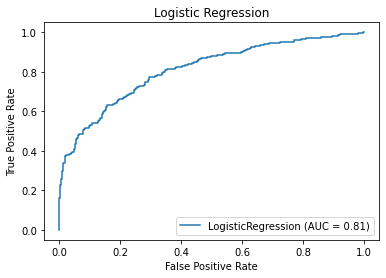

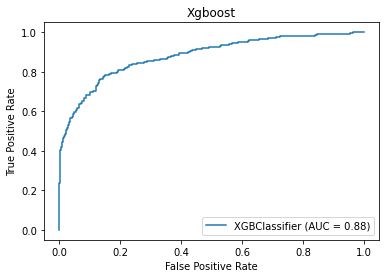

In [507]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(logr, X_test_scaled, y_test)
plt.title('Logistic Regression')
plot_roc_curve(xgbm, X_test_scaled, y_test)
plt.title('Xgboost')

In [472]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
randomseed = 42

#XGBOOST
from xgboost import XGB
xgbr = XGB(random_state=randomseed)
xgbr.fit(X_train_scaled,np.array(y_train).ravel())
predicted = xgbr.predict(X_train_scaled)
# metrics_df = metrics_df.append({'Model':'XGB',\
#                                   'MSE':mean_squared_error(np.array(y_train),np.array(predicted)),\
#                                   'MAE':mean_absolute_error(np.array(y_train),np.array(predicted)),\
#                                   'R2':r2_score(np.array(y_train),np.array(predicted)),\
#                                   'Dataset':'Train'
#                                  }, ignore_index=True)

# #RF Regressor
# from sklearn.ensemble import RandomForestRegressor
# rfr = RandomForestRegressor(random_state=randomseed) # random_state=randomseed sets the random seed for all sklearn ensemble classes
# rfr.fit(X_train_scaled,np.array(y_train).ravel())
# predicted = rfr.predict(X_train_scaled)
# metrics_df = metrics_df.append({'Model':'RF',\
#                                   'MSE':mean_squared_error(np.array(y_train),np.array(predicted)),\
#                                   'MAE':mean_absolute_error(np.array(y_train),np.array(predicted)),\
#                                   'R2':r2_score(np.array(y_train),np.array(predicted)),\
#                                   'Dataset':'Train'
#                                  }, ignore_index=True)

# #Gradient Boosting Regressor
# from sklearn.ensemble import GradientBoostingRegressor
# gbr = GradientBoostingRegressor()
# gbr.fit(X_train_scaled,np.array(y_train).ravel())
# predicted = gbr.predict(X_train_scaled)
# metrics_df = metrics_df.append({'Model':'GB',\
#                                   'MSE':mean_squared_error(np.array(y_train),np.array(predicted)),\
#                                   'MAE':mean_absolute_error(np.array(y_train),np.array(predicted)),\
#                                   'R2':r2_score(np.array(y_train),np.array(predicted)),\
#                                   'Dataset':'Train'
#                                  }, ignore_index=True)


# #Linear Model
# from sklearn.linear_model import LinearRegression
# lr = LinearRegression(fit_intercept=True)
# lr.fit(X_train_scaled,np.array(y_train).ravel())
# predicted = lr.predict(X_train_scaled)
# metrics_df = metrics_df.append({'Model':'Linear',\
#                                   'MSE':mean_squared_error(np.array(y_train),np.array(predicted)),\
#                                   'MAE':mean_absolute_error(np.array(y_train),np.array(predicted)),\
#                                   'R2':r2_score(np.array(y_train),np.array(predicted)),\
#                                   'Dataset':'Train'
#                                  }, ignore_index=True)

ImportError: cannot import name 'XGB' from 'xgboost' (C:\ProgramData\Anaconda3\lib\site-packages\xgboost\__init__.py)

In [374]:
y_test

,icu_disch_los
328,4
1160,3
2322,2
856,4
1373,2
...,...
1254,16
893,3
2931,4
2251,3


In [376]:
pd.concat([y_test.reset_index(drop=True),pd.DataFrame(predicted)],1, ignore_index=True).head(30)

,0,1
0,4,5.002877
1,3,3.483820
2,2,3.923294
3,4,5.078410
4,2,4.990180
5,10,7.612172
6,4,5.358524
7,1,4.472387
8,5,5.370438
9,3,8.088792


In [363]:
metrics_df

,Model,MSE,MAE,R2,Dataset
0,XGB,3.824702,1.284072,0.911466,Train
1,RF,6.573949,1.336086,0.847826,Train
2,GB,23.076809,2.847251,0.465816,Train
3,Linear,38.285464,3.278988,0.113765,Train
4,XGB,56.555159,3.993702,-0.106329,Test
5,RF,53.491062,3.910774,-0.046389,Test
6,GB,58.664244,3.810577,-0.147587,Test
7,Linear,46.915381,3.573836,0.082244,Test


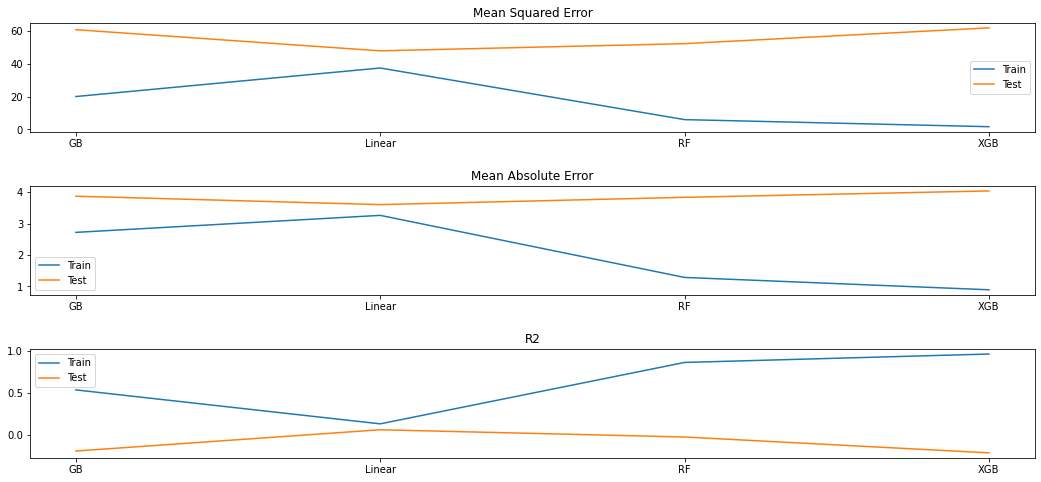

In [336]:
metrics_df = metrics_df.sort_values(by='Model')

fig,ax = plt.subplots(3,1,figsize=(18,8))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

ax[0].plot(metrics_df[metrics_df['Dataset']=='Train'].loc[:,'Model']\
         , metrics_df[metrics_df['Dataset']=='Train'].loc[:,'MSE'])

ax[0].plot(metrics_df[metrics_df['Dataset']=='Test'].loc[:,'Model']\
         , metrics_df[metrics_df['Dataset']=='Test'].loc[:,'MSE'])

ax[0].set_title('Mean Squared Error')
ax[0].legend(['Train','Test'])

ax[1].plot(metrics_df[metrics_df['Dataset']=='Train']['Model']\
         , metrics_df[metrics_df['Dataset']=='Train']['MAE'])

ax[1].plot(metrics_df[metrics_df['Dataset']=='Test']['Model']\
         , metrics_df[metrics_df['Dataset']=='Test']['MAE'])
ax[1].set_title('Mean Absolute Error')
ax[1].legend(['Train','Test'])

ax[2].plot(metrics_df[metrics_df['Dataset']=='Train']['Model']\
         , metrics_df[metrics_df['Dataset']=='Train']['R2'])

ax[2].plot(metrics_df[metrics_df['Dataset']=='Test']['Model']\
         , metrics_df[metrics_df['Dataset']=='Test']['R2'])
ax[2].set_title('R2')
ax[2].legend(['Train','Test'])

for ax in fig.axes:
    plt.sca(ax)

## Sepsis

In [70]:
query = '''
WITH ab_tbl AS 
(
  select
      abx.subject_id, abx.hadm_id, abx.stay_id
    , abx.antibiotic
    , abx.starttime AS antibiotic_time
    -- date is used to match microbiology cultures with only date available
    , abx.starttime AS antibiotic_date
    , abx.stoptime AS antibiotic_stoptime
    -- create a unique identifier for each patient antibiotic
    , ROW_NUMBER() OVER
    (
      PARTITION BY subject_id
      ORDER BY starttime, stoptime, antibiotic
    ) AS ab_id
  from mimic_derived.antibiotic abx
)
, me as
(
  select micro_specimen_id
    -- the following columns are identical for all rows of the same micro_specimen_id
    -- these aggregates simply collapse duplicates down to 1 row
    , MAX(subject_id) AS subject_id
    , MAX(hadm_id) AS hadm_id
    , CAST(MAX(chartdate) AS DATE) AS chartdate
    , MAX(charttime) AS charttime
    , MAX(spec_type_desc) AS spec_type_desc
    , max(case when org_name is not null and org_name != '' then 1 else 0 end) as PositiveCulture
  from mimic_hosp.microbiologyevents
  group by micro_specimen_id
)
-- culture followed by an antibiotic
, me_then_ab AS
(
  select
    ab_tbl.subject_id
    , ab_tbl.hadm_id
    , ab_tbl.stay_id
    , ab_tbl.ab_id
    
    , me72.micro_specimen_id
    , coalesce(me72.charttime, CAST(me72.chartdate AS DATETIME)) as last72_charttime
    , me72.positiveculture as last72_positiveculture
    , me72.spec_type_desc as last72_specimen

    -- we will use this partition to select the earliest culture before this abx
    -- this ensures each antibiotic is only matched to a single culture
    -- and consequently we have 1 row per antibiotic
    , ROW_NUMBER() OVER
    (
      PARTITION BY ab_tbl.subject_id, ab_tbl.ab_id
      ORDER BY me72.chartdate, me72.charttime NULLS LAST
    ) AS micro_seq
  from ab_tbl
  -- abx taken after culture, but no more than 72 hours after
  LEFT JOIN me me72
    on ab_tbl.subject_id = me72.subject_id
    and
    (
      (
      -- if charttime is available, use it
          me72.charttime is not null
      and ab_tbl.antibiotic_time > me72.charttime
      and ab_tbl.antibiotic_time <= DATETIME_ADD(me72.charttime, 'INTERVAL 72 HOUR') 
      )
      OR
      (
      -- if charttime is not available, use chartdate
          me72.charttime is null
      and antibiotic_date >= me72.chartdate
      and antibiotic_date <= DATE_ADD(me72.chartdate, 'INTERVAL 3 DAY')
      )
    )
)
, ab_then_me AS
(
  select
      ab_tbl.subject_id
    , ab_tbl.hadm_id
    , ab_tbl.stay_id
    , ab_tbl.ab_id
    
    , me24.micro_specimen_id
    , COALESCE(me24.charttime, CAST(me24.chartdate AS DATETIME)) as next24_charttime
    , me24.positiveculture as next24_positiveculture
    , me24.spec_type_desc as next24_specimen

    -- we will use this partition to select the earliest culture before this abx
    -- this ensures each antibiotic is only matched to a single culture
    -- and consequently we have 1 row per antibiotic
    , ROW_NUMBER() OVER
    (
      PARTITION BY ab_tbl.subject_id, ab_tbl.ab_id
      ORDER BY me24.chartdate, me24.charttime NULLS LAST
    ) AS micro_seq
  from ab_tbl
  -- culture in subsequent 24 hours
  LEFT JOIN me me24
    on ab_tbl.subject_id = me24.subject_id
    and
    (
      (
          -- if charttime is available, use it
          me24.charttime is not null
      and ab_tbl.antibiotic_time >= DATETIME_SUB(me24.charttime, 'INTERVAL 24 HOUR')  
      and ab_tbl.antibiotic_time < me24.charttime
      )
      OR
      (
          -- if charttime is not available, use chartdate
          me24.charttime is null
      and ab_tbl.antibiotic_date >= DATE_SUB(me24.chartdate, 'INTERVAL 1 DAY')
      and ab_tbl.antibiotic_date <= me24.chartdate
      )
    )
)
SELECT
ab_tbl.subject_id
, ab_tbl.stay_id
, ab_tbl.hadm_id
, ab_tbl.ab_id
, ab_tbl.antibiotic
, ab_tbl.antibiotic_time

, CASE
  WHEN last72_specimen IS NULL AND next24_specimen IS NULL
    THEN 0
  ELSE 1 
  END AS suspected_infection
-- time of suspected infection:
--    (1) the culture time (if before antibiotic)
--    (2) or the antibiotic time (if before culture)
, CASE
  WHEN last72_specimen IS NULL AND next24_specimen IS NULL
    THEN NULL
  ELSE COALESCE(last72_charttime, antibiotic_time)
  END AS suspected_infection_time

, COALESCE(last72_charttime, next24_charttime) AS culture_time

-- the specimen that was cultured
, COALESCE(last72_specimen, next24_specimen) AS specimen

-- whether the cultured specimen ended up being positive or not
, COALESCE(last72_positiveculture, next24_positiveculture) AS positive_culture

FROM ab_tbl
LEFT JOIN ab_then_me ab2me
    ON ab_tbl.subject_id = ab2me.subject_id
    AND ab_tbl.ab_id = ab2me.ab_id
    AND ab2me.micro_seq = 1
LEFT JOIN me_then_ab me2ab
    ON ab_tbl.subject_id = me2ab.subject_id
    AND ab_tbl.ab_id = me2ab.ab_id
    AND me2ab.micro_seq = 1
;

'''

oas = pd.read_sql(query,con)

DatabaseError: Execution failed on sql '
WITH ab_tbl AS 
(
  select
      abx.subject_id, abx.hadm_id, abx.stay_id
    , abx.antibiotic
    , abx.starttime AS antibiotic_time
    -- date is used to match microbiology cultures with only date available
    , abx.starttime AS antibiotic_date
    , abx.stoptime AS antibiotic_stoptime
    -- create a unique identifier for each patient antibiotic
    , ROW_NUMBER() OVER
    (
      PARTITION BY subject_id
      ORDER BY starttime, stoptime, antibiotic
    ) AS ab_id
  from mimic_derived.antibiotic abx
)
, me as
(
  select micro_specimen_id
    -- the following columns are identical for all rows of the same micro_specimen_id
    -- these aggregates simply collapse duplicates down to 1 row
    , MAX(subject_id) AS subject_id
    , MAX(hadm_id) AS hadm_id
    , CAST(MAX(chartdate) AS DATE) AS chartdate
    , MAX(charttime) AS charttime
    , MAX(spec_type_desc) AS spec_type_desc
    , max(case when org_name is not null and org_name != '' then 1 else 0 end) as PositiveCulture
  from mimic_hosp.microbiologyevents
  group by micro_specimen_id
)
-- culture followed by an antibiotic
, me_then_ab AS
(
  select
    ab_tbl.subject_id
    , ab_tbl.hadm_id
    , ab_tbl.stay_id
    , ab_tbl.ab_id
    
    , me72.micro_specimen_id
    , coalesce(me72.charttime, CAST(me72.chartdate AS DATETIME)) as last72_charttime
    , me72.positiveculture as last72_positiveculture
    , me72.spec_type_desc as last72_specimen

    -- we will use this partition to select the earliest culture before this abx
    -- this ensures each antibiotic is only matched to a single culture
    -- and consequently we have 1 row per antibiotic
    , ROW_NUMBER() OVER
    (
      PARTITION BY ab_tbl.subject_id, ab_tbl.ab_id
      ORDER BY me72.chartdate, me72.charttime NULLS LAST
    ) AS micro_seq
  from ab_tbl
  -- abx taken after culture, but no more than 72 hours after
  LEFT JOIN me me72
    on ab_tbl.subject_id = me72.subject_id
    and
    (
      (
      -- if charttime is available, use it
          me72.charttime is not null
      and ab_tbl.antibiotic_time > me72.charttime
      and ab_tbl.antibiotic_time <= DATETIME_ADD(me72.charttime, 'INTERVAL 72 HOUR') 
      )
      OR
      (
      -- if charttime is not available, use chartdate
          me72.charttime is null
      and antibiotic_date >= me72.chartdate
      and antibiotic_date <= DATE_ADD(me72.chartdate, 'INTERVAL 3 DAY')
      )
    )
)
, ab_then_me AS
(
  select
      ab_tbl.subject_id
    , ab_tbl.hadm_id
    , ab_tbl.stay_id
    , ab_tbl.ab_id
    
    , me24.micro_specimen_id
    , COALESCE(me24.charttime, CAST(me24.chartdate AS DATETIME)) as next24_charttime
    , me24.positiveculture as next24_positiveculture
    , me24.spec_type_desc as next24_specimen

    -- we will use this partition to select the earliest culture before this abx
    -- this ensures each antibiotic is only matched to a single culture
    -- and consequently we have 1 row per antibiotic
    , ROW_NUMBER() OVER
    (
      PARTITION BY ab_tbl.subject_id, ab_tbl.ab_id
      ORDER BY me24.chartdate, me24.charttime NULLS LAST
    ) AS micro_seq
  from ab_tbl
  -- culture in subsequent 24 hours
  LEFT JOIN me me24
    on ab_tbl.subject_id = me24.subject_id
    and
    (
      (
          -- if charttime is available, use it
          me24.charttime is not null
      and ab_tbl.antibiotic_time >= DATETIME_SUB(me24.charttime, 'INTERVAL 24 HOUR')  
      and ab_tbl.antibiotic_time < me24.charttime
      )
      OR
      (
          -- if charttime is not available, use chartdate
          me24.charttime is null
      and ab_tbl.antibiotic_date >= DATE_SUB(me24.chartdate, 'INTERVAL 1 DAY')
      and ab_tbl.antibiotic_date <= me24.chartdate
      )
    )
)
SELECT
ab_tbl.subject_id
, ab_tbl.stay_id
, ab_tbl.hadm_id
, ab_tbl.ab_id
, ab_tbl.antibiotic
, ab_tbl.antibiotic_time

, CASE
  WHEN last72_specimen IS NULL AND next24_specimen IS NULL
    THEN 0
  ELSE 1 
  END AS suspected_infection
-- time of suspected infection:
--    (1) the culture time (if before antibiotic)
--    (2) or the antibiotic time (if before culture)
, CASE
  WHEN last72_specimen IS NULL AND next24_specimen IS NULL
    THEN NULL
  ELSE COALESCE(last72_charttime, antibiotic_time)
  END AS suspected_infection_time

, COALESCE(last72_charttime, next24_charttime) AS culture_time

-- the specimen that was cultured
, COALESCE(last72_specimen, next24_specimen) AS specimen

-- whether the cultured specimen ended up being positive or not
, COALESCE(last72_positiveculture, next24_positiveculture) AS positive_culture

FROM ab_tbl
LEFT JOIN ab_then_me ab2me
    ON ab_tbl.subject_id = ab2me.subject_id
    AND ab_tbl.ab_id = ab2me.ab_id
    AND ab2me.micro_seq = 1
LEFT JOIN me_then_ab me2ab
    ON ab_tbl.subject_id = me2ab.subject_id
    AND ab_tbl.ab_id = me2ab.ab_id
    AND me2ab.micro_seq = 1
;

': invalid input syntax for type interval: "INTERVAL 72 HOUR"
LINE 65: ...l.antibiotic_time <= DATETIME_ADD(me72.charttime, 'INTERVAL ...
                                                              ^


In [6]:
%%time
# query = 'SELECT * FROM admissions limit 500'

# query = '''
# SELECT *
# FROM mimic_core.patients pat
# JOIN mimic_core.admissions adm on pat.subject_id = adm.subject_id
# JOIN mimic_icu.icustays icu on adm.subject_id = icu.subject_id and adm.hadm_id = icu.hadm_id
# JOIN (select hadm_id  , min(intime) as min_intime FROM mimic_icu.icustays GROUP BY hadm_id ) first_ on icu.hadm_id = first_.hadm_id and icu.intime = first_.min_intime
# --on adm.hadm_id = first_icu.hadm_id
# WHERE  pat.anchor_age >= 18
# AND adm.hospital_expire_flag = 0
# AND icu.stay_id = 30000010
# AND icu.subject_id in (select subject_id from mimic_derived.ventilator_setting where extubated = 1 )
# limit 1000
# '''

# query = '''
# select

# a.stay_id, a.charttime, a.storetime, a.value as device , b.value as mode ,b.valuenum
# from

# (
# select  stay_id,charttime,storetime,value,valuenum from chartevents 
# where itemid  = '223848' 
# and lower(value) in ('drager','avea','pb 7200','sensor medic (hfo)','hamilton')

# ) a

# join
# (
#  select  stay_id,charttime,storetime,value,valuenum from chartevents
# where itemid = '223849'

# ) b

# on a.stay_id = b.stay_id and a.charttime = b.charttime

# '''

# vent = pd.read_sql(query, con)
